In [10]:
import pandas as pd
import numpy as np
import json
import pickle
from collections import Counter, defaultdict
from itertools import product
from sklearn.metrics import confusion_matrix
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from bidict import bidict
from statistics import mean, mode
from multiprocessing import Process
import random
import sys
import os
import re
import kenlm
import matplotlib.pyplot as plt
import seaborn as sns
import gc

In [11]:
%matplotlib inline
plt.style.use(['dark_background', 'ggplot'])
sns.set(color_codes=True)
sns.set_palette(sns.color_palette('dark'))

In [12]:
def to_python_lists(np_arr, lengths):
    return [row[:length] for row, length in zip(np_arr, lengths)]

def count_transitions(sequences):
    trans = [list(zip(seq[:-1], seq[1:])) for seq in sequences]
    trans = sum(trans, [])
    
    return Counter(trans)

def normalize_counter(counts):
    total = sum(counts.values(), 0)
    for key in counts:
        counts[key] /= total
    
    return counts

def get_ngrams(n, tokens):    
    return [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

def get_index(target, top_preds):    
    indices = np.where(top_preds == target)[0]
    if len(indices) == 0:
        return -1
    
    return indices[0]

# Load Datasets

In [13]:
path550 = "/data/rali7/Tmp/solimanz/data/datasets/top550/"
path7k = "/data/rali7/Tmp/solimanz/data/datasets/reduced7000/"

# Load data dicts
with open(os.path.join(path550, "jobid", "data.json"), "r") as f:
    data550 = json.load(f)
with open(os.path.join(path7k, "jobid", "data.json"), "r") as f:
    data7k = json.load(f)

In [6]:
len(data7k["train_data"]) + len(data7k["test_data"])

837999

In [14]:
res550 = dict()
res7k = dict()

# Helper Methods to Fetch Predictive Model Results

In [15]:
def fetch_ngram_results(res_dict=None, dataset="top550"):
    """
    Fetch saved numpy matices of ngram prediction probabilities
    """
    if res_dict is None:
        res_dict = dict()
    
    models = ["bigram", "trigram", "4gram", "5gram"]
    ngram_preds_path = f"/data/rali7/Tmp/solimanz/data/ngram_preds/{dataset}"
    for model in models:
        res_dict[model] = np.load(os.path.join(ngram_preds_path, model + '.npy'))

In [16]:
def next_batch(path):
    batch = 0
    name = os.path.basename(path)
    while os.path.exists(os.path.join(path, f"{name}_batch_{batch}.npy")):
        with open(os.path.join(path, f"{name}_batch_{batch}.npy"), "rb") as f:
            matrix = np.load(f)
        batch += 1
        yield matrix
        
def get_neural_predictions(model, dataset):
    result_path = "/data/rali7/Tmp/solimanz/data/model_predictions"
    gen = next_batch(os.path.join(result_path, dataset, model, "predictions"))
    length_gen = next_batch(os.path.join(result_path, dataset, "fasttext", "seq_lengths"))
    predictions = []
    print(f"Fetching {model} for {dataset}...")
    for preds, lengths in zip(gen, length_gen):
        if model == "fasttext":
            p = np.array([row[:seq_len,:][-1] for row, seq_len in zip(preds, lengths)])
        elif len(preds.shape) == 3:
            p = preds[0]
        else:
            p = preds
            
        predictions.append((-p).argsort(axis=1)[:, :10])
    print(f"Fetched {model} for {dataset} completly")
    predictions = np.concatenate(predictions)
    
    return predictions

# Predict Most Probable Baseline (MoPro)

In [17]:
# MoPro
class MostProbable():
    
    def train(self, train, count_last=True):
        if count_last:
            counts = Counter([d[1][-1] for d in train])
            self.prediction = counts.most_common(1)[0][0]
        else:
            counts = Counter(sum([d[1] for d in train], []))
            self.prediction = counts.most_common(1)[0][0]
    
    def predict(self, test):        
        return np.array([self.prediction] * len(test))

In [18]:
most_prb_550 = MostProbable()
most_prb_550.train(data550['train_data'], True)
res550['MoPro'] = most_prb_550.predict(data550['test_data'])

In [19]:
most_prb_7k = MostProbable()
most_prb_7k.train(data7k['train_data'], True)
res7k['MoPro'] = most_prb_7k.predict(data7k['test_data'])

# Predict Last Baseline (PreLA)

In [20]:
#PreLa
def predict_last(test):
    return np.array([d[1][-2] for d in test])

In [21]:
res550['PreLa'] = predict_last(data550['test_data'])
res7k['PreLa'] = predict_last(data7k['test_data'])

# Analysis

## Distribution of Job Title Targets

In [22]:
# From Training Data Set
train_targets_550 = normalize_counter(Counter([d[1][-1] for d in data550['train_data']]))
train_targets_7k = normalize_counter(Counter([d[1][-1] for d in data7k['train_data']]))

In [23]:
sorted_550 = train_targets_550.most_common(len(train_targets_550))
sorted_7k = train_targets_7k.most_common(len(train_targets_7k))

In [24]:
mapping_550 = bidict({t[0]: i for i, t in enumerate(sorted_550)})
mapping_7k = bidict({t[0]: i for i, t in enumerate(sorted_7k)})

In [25]:
x1 , y1 = zip(*sorted_550)
x1 = [mapping_550[i] for i in x1]

x2 , y2 = zip(*sorted_7k)
x2 = [mapping_7k[i] for i in x2]

Text(0,0.5,'Frequency')

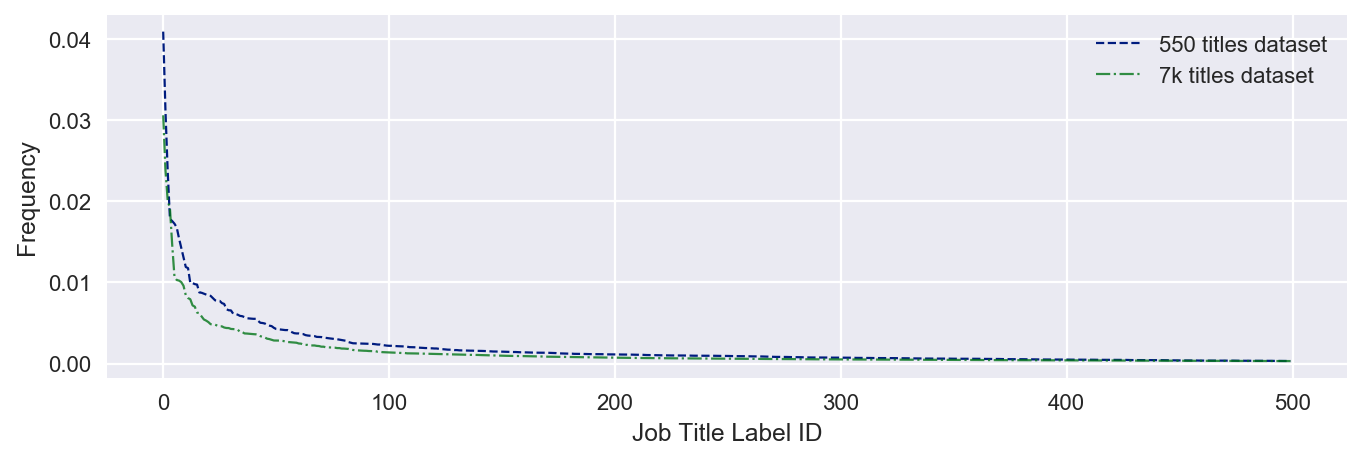

In [26]:
plt.rcParams['figure.dpi'] = 160
plt.rcParams['figure.figsize'] = (10,3)
plt.rcParams['lines.linewidth'] = 1
fig = plt.gcf()
plt.plot(x1[:500], y1[:500], '--', markersize=4, label='550 titles dataset')
plt.plot(x2[:500], y2[:500], '-.', markersize=4, alpha=0.8, label='7k titles dataset')
plt.legend()
plt.xlabel('Job Title Label ID')
plt.ylabel('Frequency')

In [18]:
fig.savefig('../../../Dropbox/thesis/thesis/images/title_dist.png', dpi=180, facecolor=fig.get_facecolor())

## Accuracy Comparison

In [27]:
targets_550 = np.array([d[1][-1] for d in data550['test_data']])
targets_7k = np.array([d[1][-1] for d in data7k['test_data']])

In [28]:
def top_k_acc(preds, targets, k=1):
    """
    preds has shape (n_examples, n_labels)
    targets has shape (n_examples, 1)
    """

    #sorted_args = (-preds).argsort(axis=1)[:,:k]
    if len(preds.shape) == 1:
        acc = np.mean(preds == targets)
    else:
        sorted_args = preds[:,:k]
        tt = np.tile(targets, (k,1)).T
        acc = np.mean(np.sum(sorted_args == tt, axis=1))
    return acc

def get_acc_df(preds, targets, dataset):
    
    ks = list(range(1,11))
    df_dict = {
    'dataset': [],
    'top_k': [],
    'model': [],
    'accuracy': []
    }

    for name, ps in preds.items():
        for k in ks:
            df_dict['dataset'].append(dataset)
            df_dict["model"].append(name)
            df_dict["top_k"].append(k)
            df_dict["accuracy"].append(round(top_k_acc(ps, targets, k), 5))
            
    return pd.DataFrame(df_dict)

### N-gram Models

### Fetch Models

In [29]:
fetch_ngram_results(res550)
fetch_ngram_results(res7k, "reduced7k")

In [30]:
accs_550 = get_acc_df(res550, targets_550, '550_titles')
accs_7k = get_acc_df(res7k, targets_7k, '7k_titles')

In [31]:
models = ['trigram', '4gram', '5gram', 'bigram']

Text(0.5,1,'7k Titles Dataset')

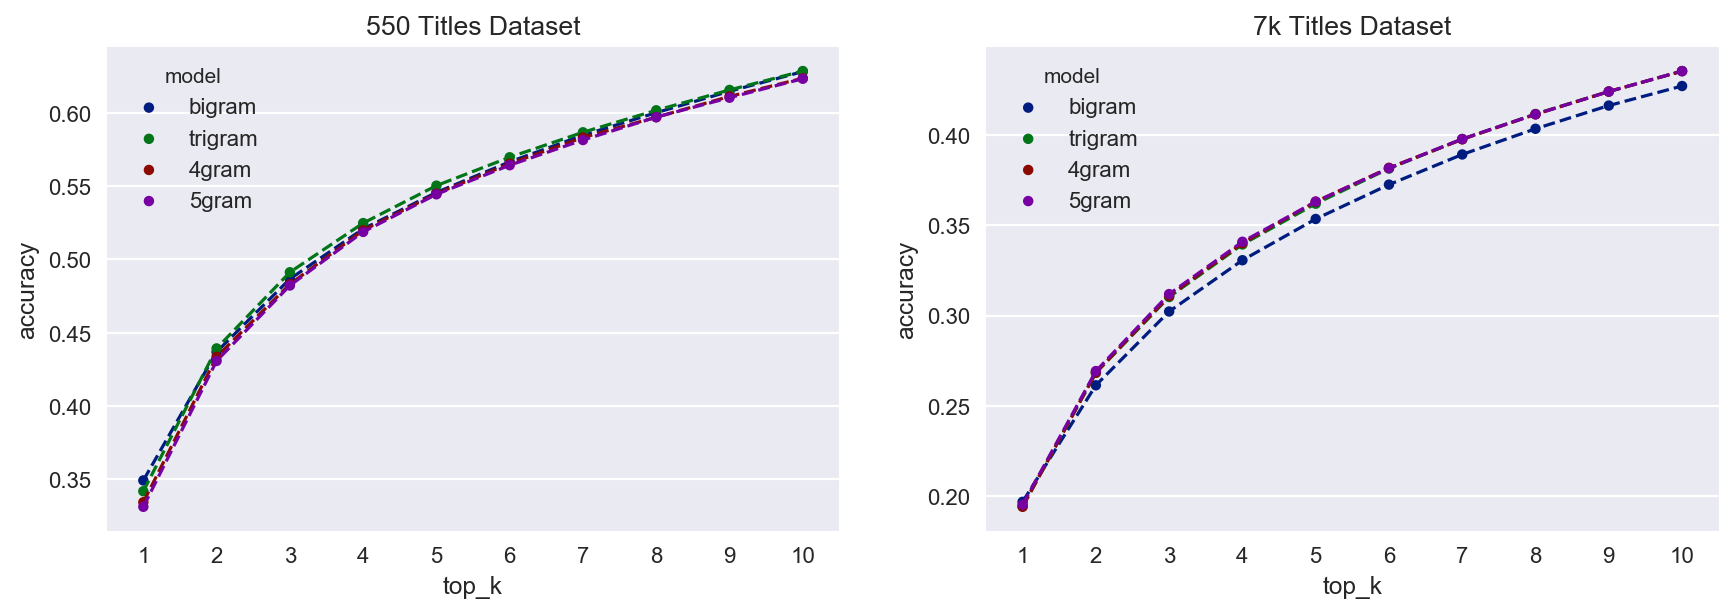

In [24]:
plt.rcParams['figure.dpi'] = 160
plt.rcParams['lines.linewidth'] = 0.8
fig, ax = plt.subplots(figsize=(13,4), ncols=2, nrows=1)
sns.pointplot(x='top_k', y='accuracy', hue='model', alpha=0.3, linestyles='--',
              data=accs_550[accs_550.model.isin(models)], ax=ax[0])
sns.pointplot(x='top_k', y='accuracy', hue='model', alpha=0.3, linestyles='--',
              data=accs_7k[accs_7k.model.isin(models)], ax=ax[1])
ax[0].set_title('550 Titles Dataset')
ax[1].set_title('7k Titles Dataset')

In [25]:
print(sum([len(d[1]) > 5 for d in data550['train_data']]))
print(sum([len(d[1]) > 5 for d in data7k['train_data']]))

5646
120122


In [26]:
fig.savefig('../../../Dropbox/thesis/thesis/images/ngram_res.png', dpi=180, facecolor=fig.get_facecolor())

### Neuronal Models

In [42]:
models = ['jobid', 'bow', 'fasttext']
datasets = ['top550', 'reduced7k']
for model, dataset in product(models, datasets):
    if dataset == 'top550':
        res550[model] = get_neural_predictions(model, dataset)
    elif dataset == 'reduced7k':
        res7k[model] = get_neural_predictions(model, dataset)

Fetching jobid for top550...
Fetched jobid for top550 completly
Fetching jobid for reduced7k...
Fetched jobid for reduced7k completly
Fetching bow for top550...
Fetched bow for top550 completly
Fetching bow for reduced7k...
Fetched bow for reduced7k completly
Fetching fasttext for top550...
Fetched fasttext for top550 completly
Fetching fasttext for reduced7k...
Fetched fasttext for reduced7k completly


### Dump Result Dictionaries

In [99]:
with open("/part/01/Tmp/solimanz/data/res550.pkl", "wb") as f:
    pickle.dump(file=f, obj=res550)
with open("/part/01/Tmp/solimanz/data/res7k.pkl", "wb") as f:
    pickle.dump(file=f, obj=res7k)

### Load Result Dictionaries

In [33]:
with open("/data/rali7/Tmp/solimanz/data/res550.pkl", "rb") as f:
    res550 = pickle.load(f)
with open("/data/rali7/Tmp/solimanz/data/res7k.pkl", "rb") as f:
    res7k = pickle.load(f)

In [29]:
accs_550 = get_acc_df(res550, targets_550, '550_titles')
accs_7k = get_acc_df(res7k, targets_7k, '7k_titles')

In [30]:
models = ['jobid', 'bow', 'fasttext']

Text(0.5,1,'7k Titles Dataset')

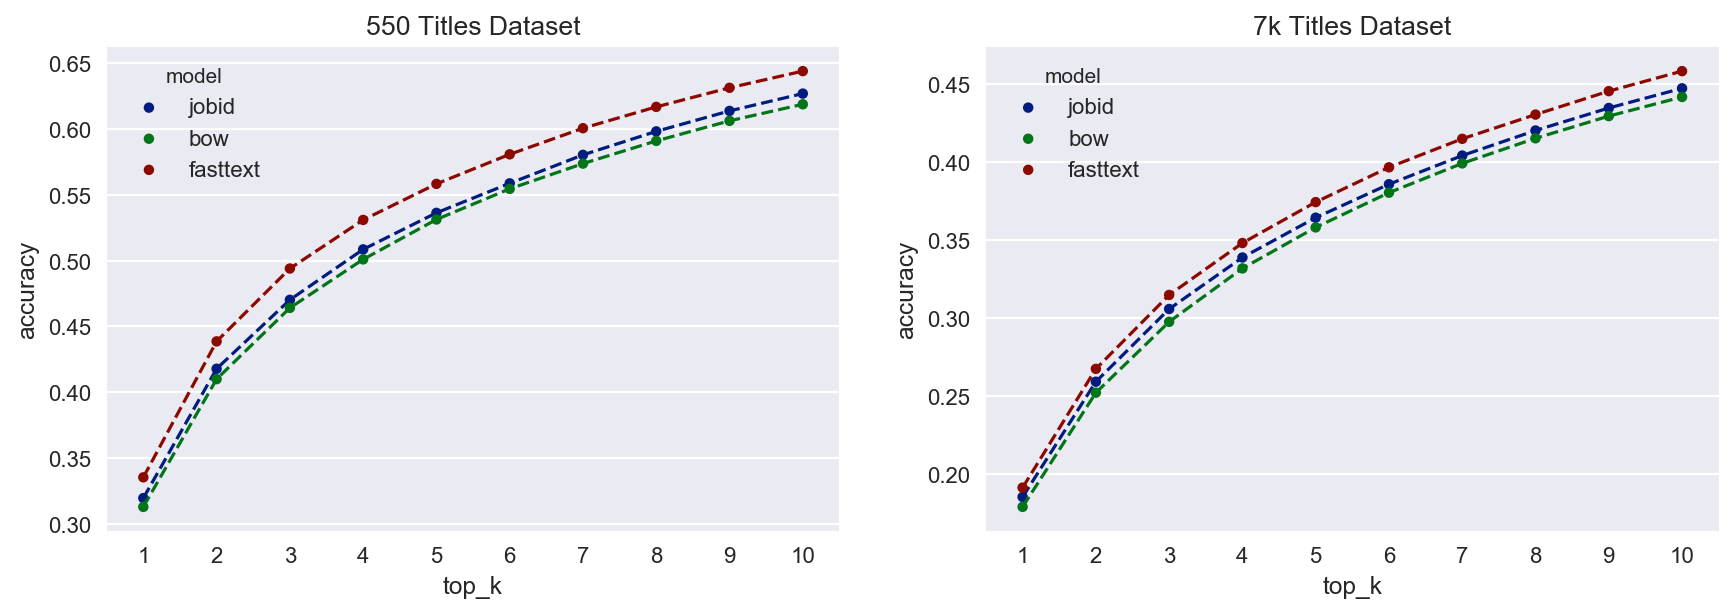

In [31]:
plt.rcParams['figure.dpi'] = 160
plt.rcParams['lines.linewidth'] = 0.8
fig, ax = plt.subplots(figsize=(13,4), ncols=2, nrows=1)
sns.pointplot(x='top_k', y='accuracy', hue='model', alpha=0.3, linestyles='--', 
              data=accs_550[accs_550.model.isin(models)], ax=ax[0])
sns.pointplot(x='top_k', y='accuracy', hue='model', alpha=0.3, linestyles='--', 
              data=accs_7k[accs_7k.model.isin(models)], ax=ax[1])
ax[0].set_title('550 Titles Dataset')
ax[1].set_title('7k Titles Dataset')

In [32]:
fig.savefig('../../../Dropbox/thesis/thesis/images/lstm_res.png', dpi=180, facecolor=fig.get_facecolor())

### Comparing Best Models

#### Fetch Naive Bayes Models

In [33]:
def fetch_nb_results(model='multi_nb_550', res_dict=None):
    if res_dict is None:
        res_dict = dict()
    ngram_preds_path = "/data/rali7/Tmp/solimanz/data/nb_preds/"
    
    preds = np.load(os.path.join(ngram_preds_path, model + '.npy'))
    res_dict["multi_nb"] = (-preds).argsort(axis=1)[:, :10]

In [34]:
fetch_nb_results('multi_nb_550', res550)
fetch_nb_results('multi_nb_7k', res7k)

In [37]:
print(res550.keys())
print(res7k.keys())

dict_keys(['MoPro', 'PreLa', 'bigram', 'trigram', '4gram', '5gram', 'jobid', 'bow', 'fasttext', 'multi_nb'])
dict_keys(['MoPro', 'PreLa', 'bigram', 'trigram', '4gram', '5gram', 'jobid', 'bow', 'fasttext', 'multi_nb'])


In [38]:
models550 = ['bigram', 'fasttext', 'multi_nb', 'MoPro', 'PreLa']
models7k = ['5gram', 'fasttext', 'multi_nb', 'MoPro', 'PreLa']

In [39]:
accs_550 = get_acc_df(res550, targets_550, '550_titles')
accs_7k = get_acc_df(res7k, targets_7k, '7k_titles')

Text(0.5,1,'7k Titles Dataset')

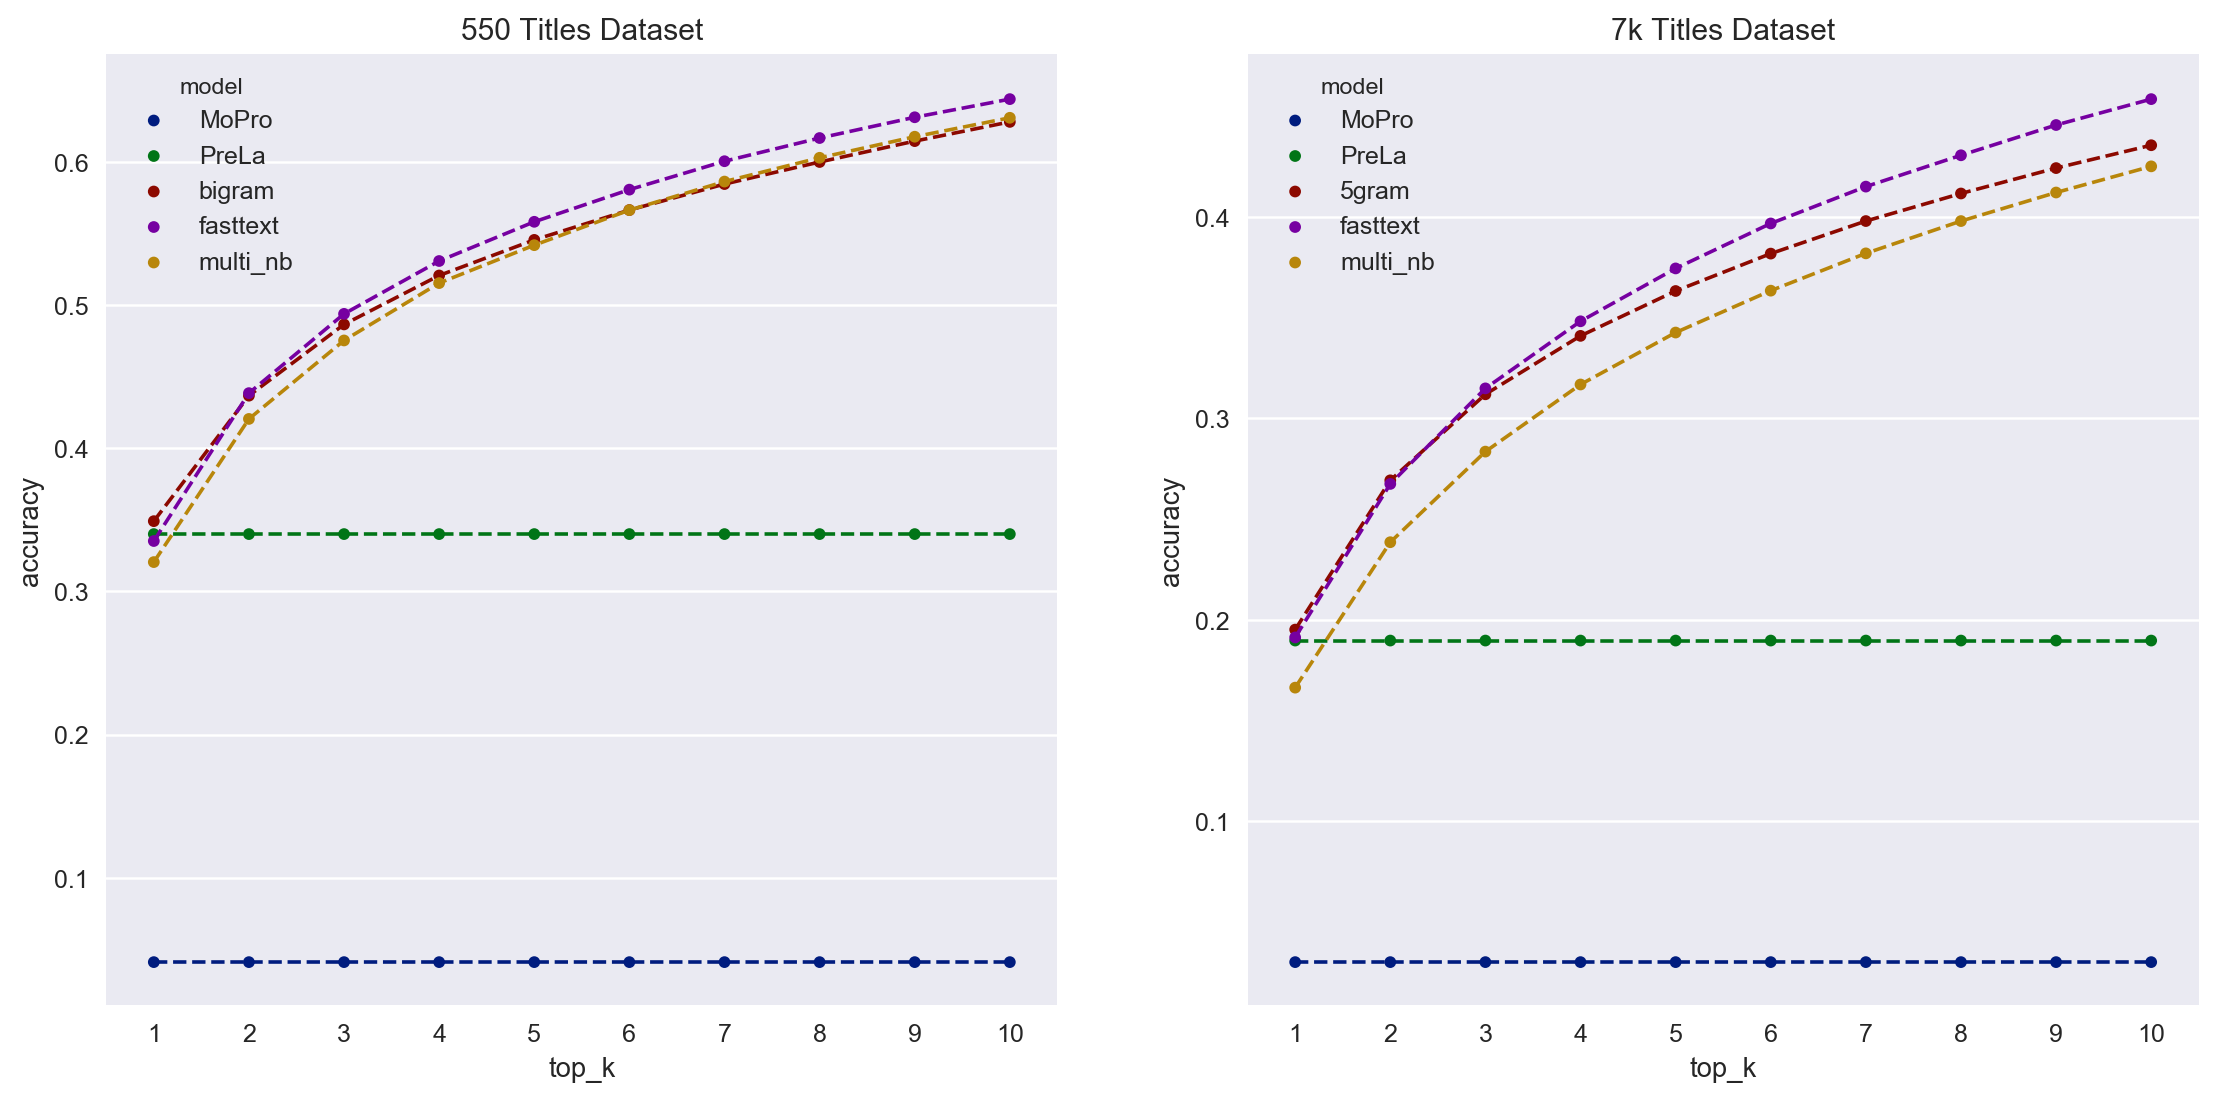

In [41]:
plt.rcParams['figure.dpi'] = 180
plt.rcParams['lines.linewidth'] = 0.8
fig, ax = plt.subplots(figsize=(15,7), ncols=2, nrows=1)
sns.pointplot(x='top_k', y='accuracy', hue='model', alpha=0.3, linestyles='--', 
              data=accs_550[accs_550.model.isin(models550)], ax=ax[0])
sns.pointplot(x='top_k', y='accuracy', hue='model', alpha=0.3, linestyles='--', 
              data=accs_7k[accs_7k.model.isin(models7k)], ax=ax[1])
ax[0].set_title('550 Titles Dataset')
ax[1].set_title('7k Titles Dataset')

In [42]:
fig.savefig('../../../Dropbox/thesis/thesis/images/all_res.png', dpi=180, facecolor=fig.get_facecolor())

In [43]:
all_550 = data550['train_data'] + data550['test_data']
all_7k = data7k['train_data'] + data7k['test_data']

In [44]:
print(mean([d[1][-1] == d[1][-2] for d in all_550]))
print(mean([d[1][-1] == d[1][-2] for d in all_7k]))

0.3415141741358296
0.18871263569526933


## Accuracy by Length

In [34]:
def groupby_length(seq_lengths):
    d = dict()
    lengths = seq_lengths - 1
    for i in range(2, lengths.max()+1):
        d[i] = np.where(lengths == i)[0]
    return d
        
def accuracy_by_length(preds_dict, targets, seq_lengths, k=1):
    """
    preds: predictions of the model (n_examples, max_length, n_labels)
    targets: prediction targets with shape (n_examples, max_lenth, n_labels)
    groups: dictionary grouping the indices of the input sequences by length
    """
    groups = groupby_length(seq_lengths)
    accs = defaultdict(list)
    for length, indices in groups.items():
        if len(indices) > 0:
            for model, preds in preds_dict.items():
                p = preds[indices]
                t = targets[indices]
                accs['accuracy'].append(top_k_acc(p, t, k))
                accs['length'].append(length)
                accs['model'].append(model)
                
    return pd.DataFrame(accs)

In [35]:
seq_lengths_550 = np.array([len(d[1]) for d in data550['test_data']])
seq_lengths_7k = np.array([len(d[1]) for d in data7k['test_data']])

train_lengths_550 = Counter([len(d[1]) - 1 for d in data550['train_data'] if len(d[1]) <= 10])
train_lengths_7k = Counter([len(d[1]) - 1 for d in data7k['train_data'] if len(d[1]) <= 10])

In [36]:
lengths550, counts550 = zip(*train_lengths_550.most_common())
lengths7k, counts7k = zip(*train_lengths_7k.items())

In [37]:
lengths550 = [l-2 for l in lengths550]
lengths7k = [l-2 for l in lengths7k]

In [38]:
df550 = accuracy_by_length(res550, targets_550, seq_lengths_550)
df7k = accuracy_by_length(res7k, targets_7k, seq_lengths_7k)

In [39]:
models550 = ['bigram', 'fasttext', 'multi_nb', 'PreLa']
models7k = ['5gram', 'fasttext', 'multi_nb', 'PreLa']
dat550 = df550[df550.model.isin(models550)]
dat550 = dat550[dat550.length <= 9]

dat7k = df7k[df7k.model.isin(models7k)]
dat7k = dat7k[dat7k.length <= 9]

Text(0.5,1,'7k Titles Dataset')

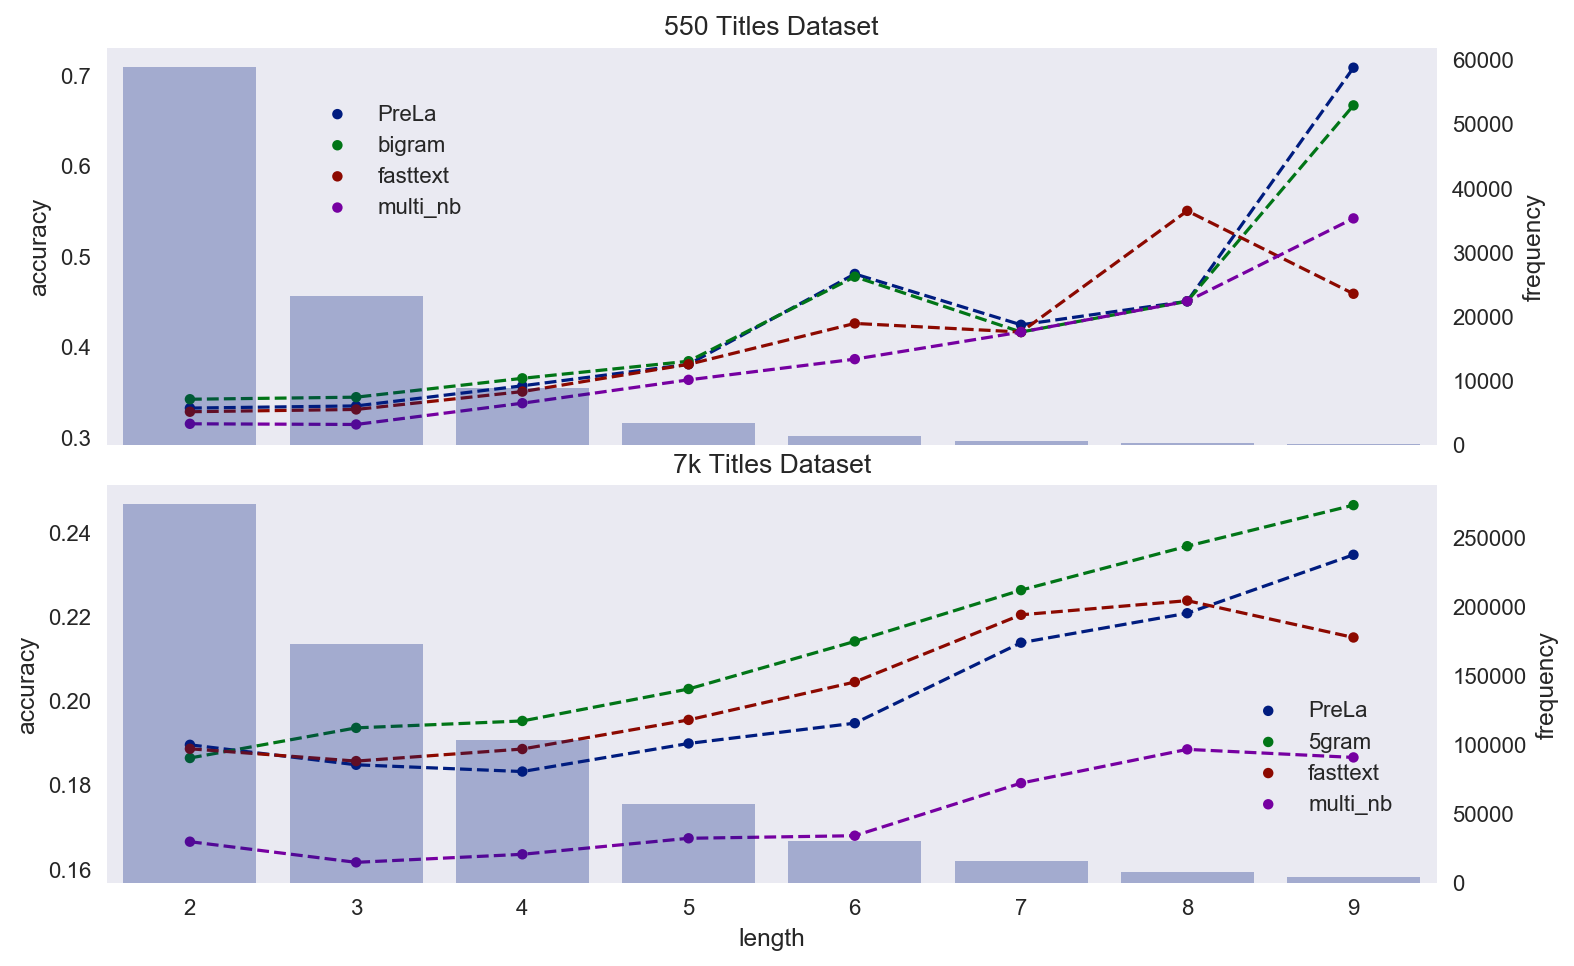

In [40]:
plt.rcParams['figure.dpi'] = 160
plt.rcParams['lines.linewidth'] = 0.8
fig, ax = plt.subplots(figsize=(10,6), ncols=1, nrows=2, sharex=True)

sns.pointplot(x='length', y='accuracy', hue='model', alpha=0.3, linestyles='--', 
              data=dat550, ax=ax[0])
ax1 = ax[0].twinx()
ax1.bar(lengths550, counts550, alpha=0.3)
ax1.set_ylabel('frequency')
ax[0].set_xlabel('')


sns.pointplot(x='length', y='accuracy', hue='model', alpha=0.3, linestyles='--', 
              data=dat7k, ax=ax[1])
ax2 = ax[1].twinx()
ax2.bar(lengths7k, counts7k, alpha=0.3)
ax2.set_ylabel('frequency')

ax[0].legend(loc=(0.15, 0.55))
ax[0].grid(False)
ax1.grid(False)

ax[1].legend(loc=(0.85, 0.15))
ax[1].grid(False)
ax2.grid(False)

plt.tight_layout()
ax[0].set_title('550 Titles Dataset')
ax[1].set_title('7k Titles Dataset')

In [41]:
fig.savefig('../../../Dropbox/thesis/thesis/images/acc_length.png', dpi=180, facecolor=fig.get_facecolor())

## Frequency of change Through time

In [86]:
seqs_trans_550 = [get_ngrams(2, d[1]) for d in data550['train_data']]
seqs_trans_7k = [get_ngrams(2, d[1]) for d in data7k['train_data']]

In [87]:
def compute_change_freq(seqs_trans, max_len):
    change_freq = {}
    totals = {}

    for i in range(max_len):
        changed = 0.0
        total = 0.0
        for seq in seqs_trans:
            if i < len(seq):
                total += 1
                trans = seq[i]
                if trans[0] != trans[1]:
                    changed += 1
        
        if total > 0:
            change_freq[i+1] = changed/total
        else:
            change_freq[i+1] = 0
            
        totals[i+1] = total
        
    return change_freq, totals

In [88]:
change_freq_550, tots_550 = compute_change_freq(seqs_trans_550, data550['maximum_seq_len'])
change_freq_7k, tots_7k = compute_change_freq(seqs_trans_7k, data7k['maximum_seq_len'])

In [89]:
x1 = []
y1 = []

for k, v in change_freq_550.items():
    x1.append(k)
    y1.append(v)
    
x2 = []
y2 = []

for k, v in change_freq_7k.items():
    x2.append(k)
    y2.append(v) 

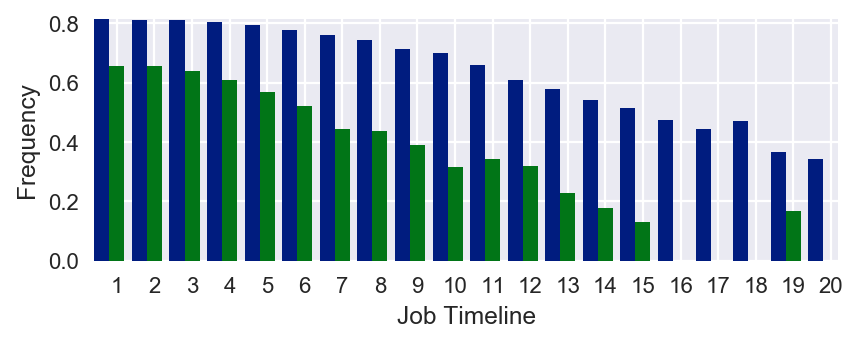

In [90]:
plt.rcParams['figure.dpi'] = 160
plt.rcParams['figure.figsize'] = (6,2)
plt.rcParams['lines.linewidth'] = 1
fig = plt.gcf()
ax = plt.subplot(111)
w = 0.4
ax.bar(np.array(x2[:20]) - w, y2[:20], width=w, align='center')
ax.bar(np.array(x1[:20]), y1[:20], width=w, align='center')
#plt.title("Frequency of Job Title Change Through Time")
plt.ylabel("Frequency")
plt.xlabel("Job Timeline")
ax.autoscale(tight=True)
ticks = ax.set_xticks(np.arange(1,21))

In [91]:
fig.savefig('../../../Dropbox/thesis/thesis/images/freq_change.png', dpi=180, facecolor=fig.get_facecolor())

## Prediction Targets Frequency

In [92]:
targets_length_550 = dict()
targets_length_7k = dict()

for i in range(2, 10):
    selection550 = [seq[1] for seq in data550['test_data'] if len(seq[1]) - 1 == i]
    selection7k = [seq[1] for seq in data7k['test_data'] if len(seq[1]) - 1 == i]
    
    targets_length_550[i] = [seq[-1] for seq in selection550]
    targets_length_7k[i] = [seq[-1] for seq in selection7k]

In [93]:
# From Training Data Set
train_targets_550 = normalize_counter(Counter([d[1][-1] for d in data550['train_data']]))
train_targets_7k = normalize_counter(Counter([d[1][-1] for d in data7k['train_data']]))

In [94]:
sorted_550 = train_targets_550.most_common(len(train_targets_550))
sorted_7k = train_targets_7k.most_common(len(train_targets_7k))

In [95]:
mapping_550 = bidict({t[0]: i for i, t in enumerate(sorted_550)})
mapping_7k = bidict({t[0]: i for i, t in enumerate(sorted_7k)})

In [96]:
x1 , y1 = zip(*sorted_550)
x1 = [mapping_550[i] for i in x1]

x2 , y2 = zip(*sorted_7k)
x2 = [mapping_7k[i] for i in x2]

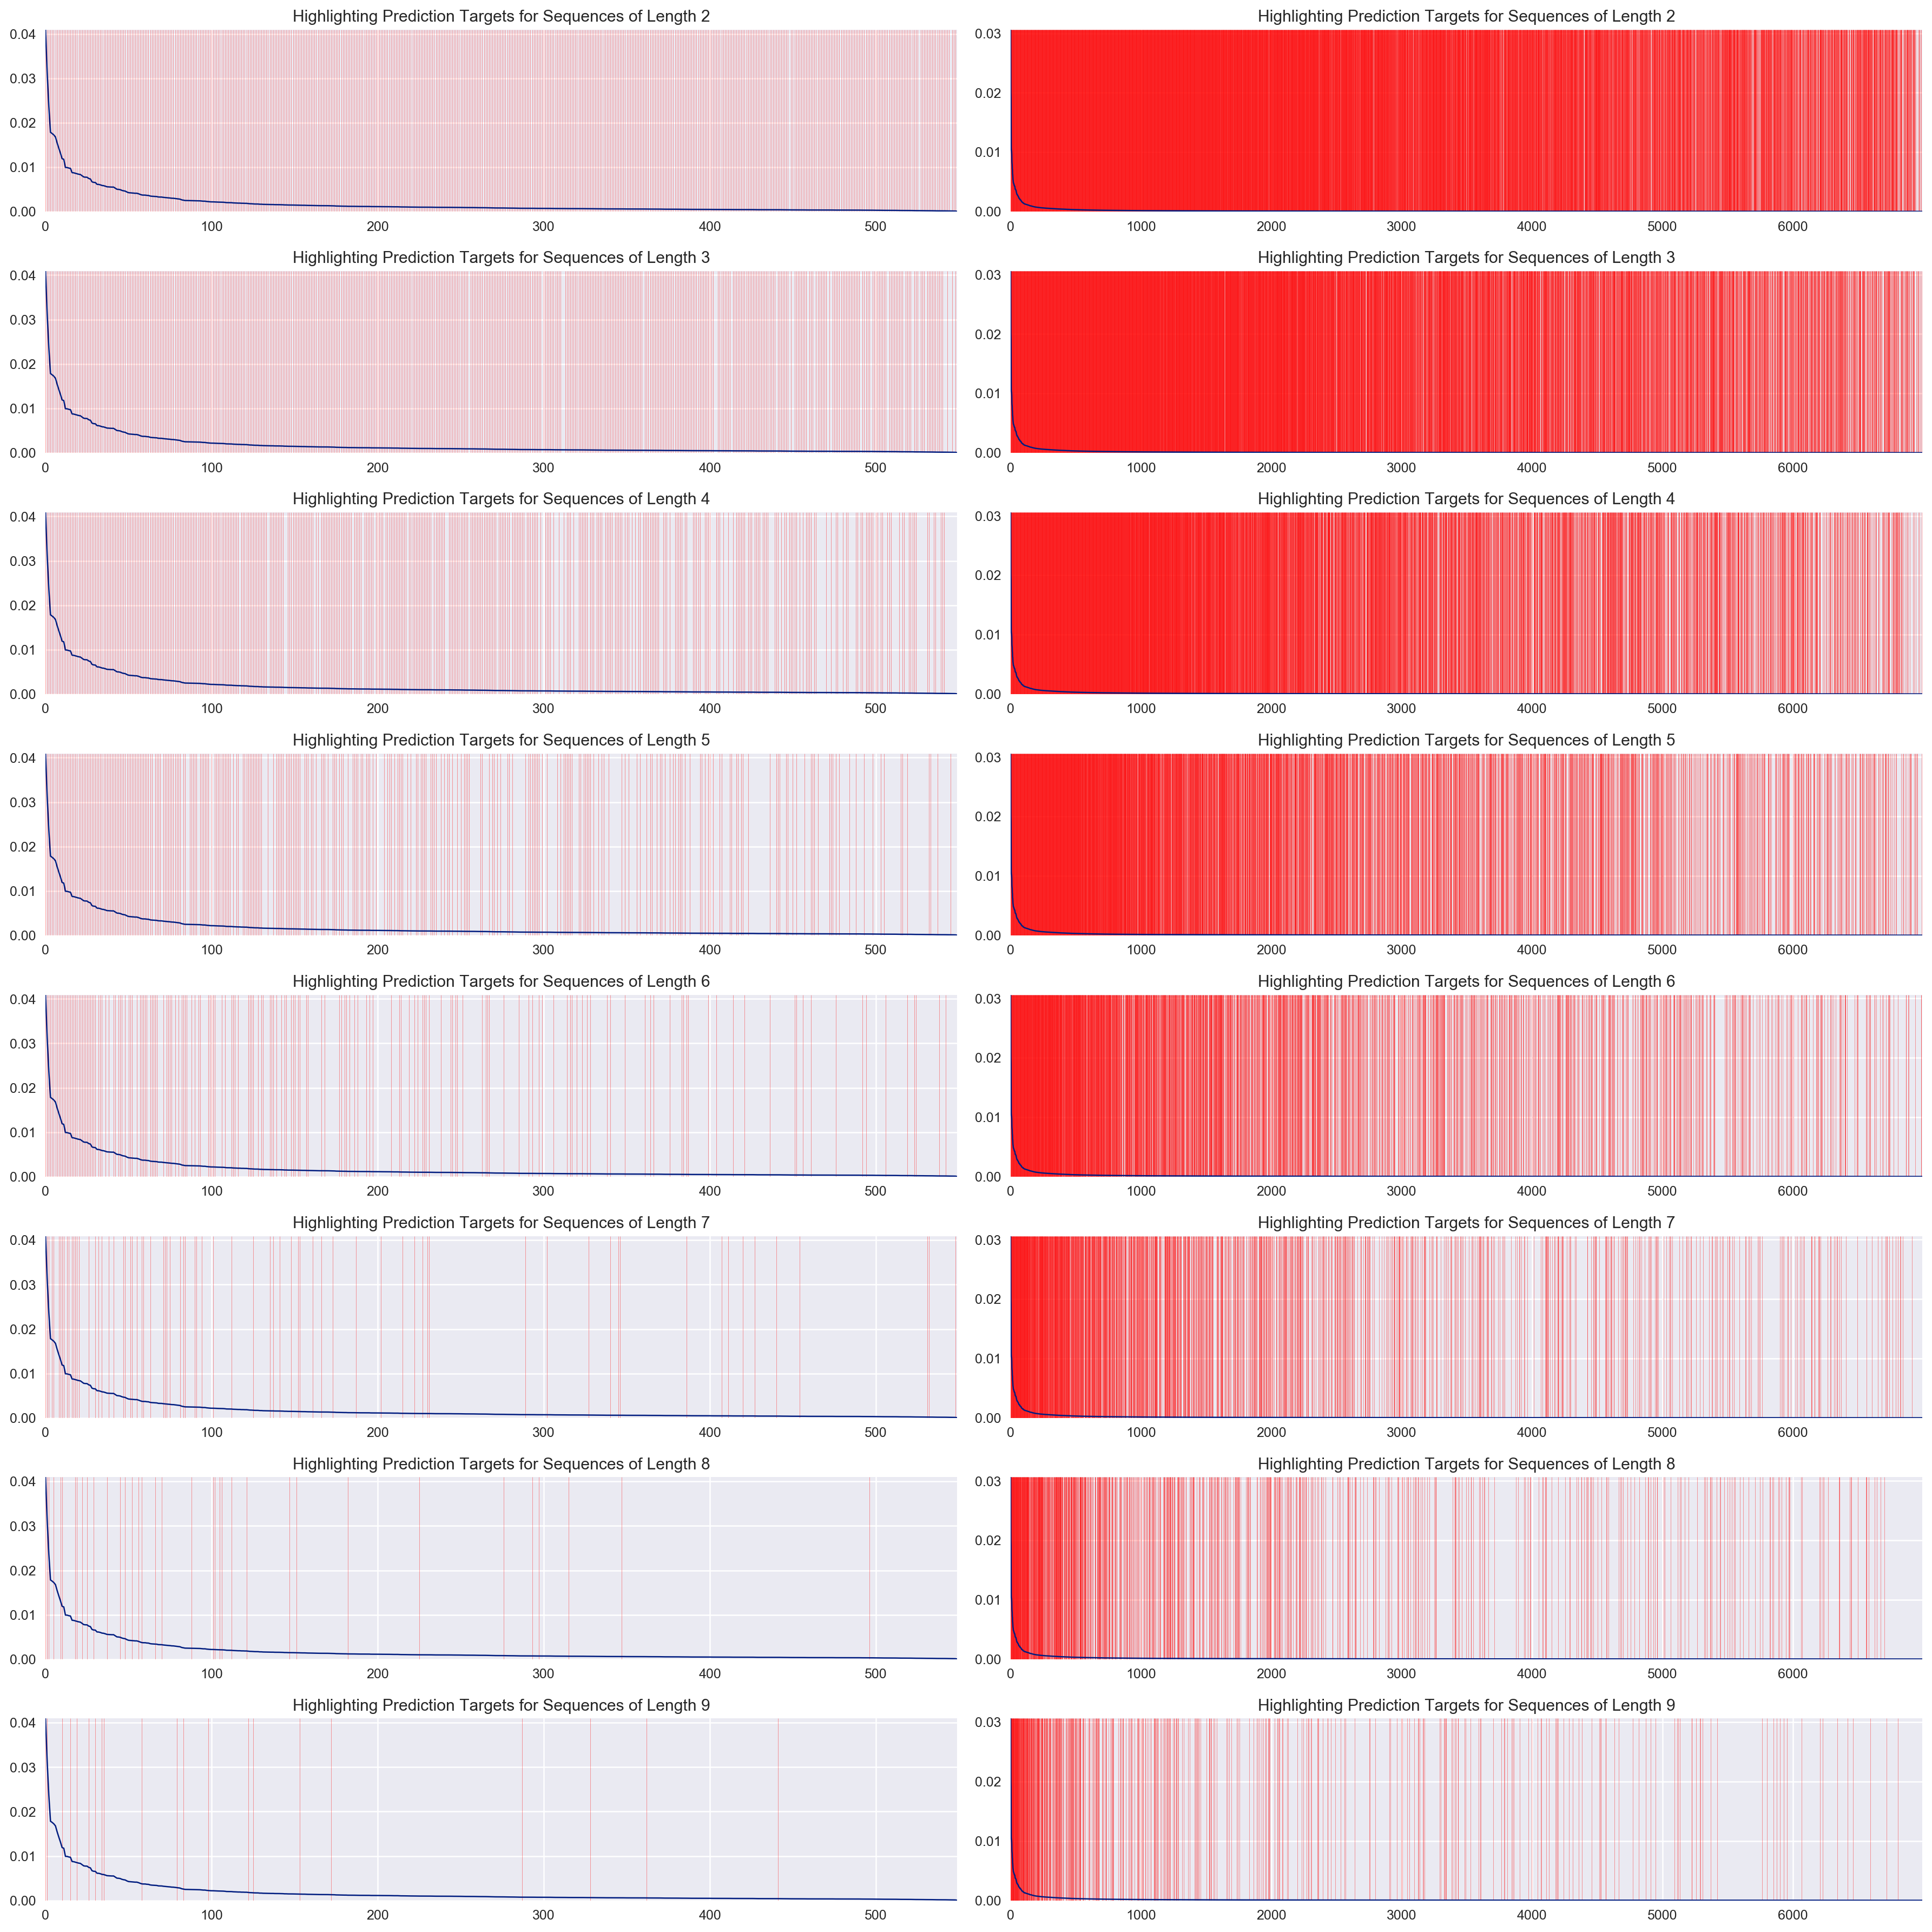

In [102]:
plt.rcParams['figure.figsize'] = 15, 15
plt.rcParams['figure.dpi'] = 180

lengths = [2,3,4,5,6,7,8,9]
f, axarr = plt.subplots(len(lengths), 2 , figsize=(20,20), sharex=False)

for i, length in enumerate(lengths):
    axarr[i][0].plot(x1, y1)
    for target in set(targets_length_550[length]):
        if target in mapping_550:
            axarr[i][0].axvspan(mapping_550[target],mapping_550[target], color='red', alpha=0.5)
    axarr[i][0].set_title(f'Highlighting Prediction Targets for Sequences of Length {length}')
    axarr[i][0].autoscale(tight=True)
    
for i, length in enumerate(lengths):
    axarr[i][1].plot(x2, y2)
    for target in set(targets_length_7k[length]):
        if target in mapping_7k:
            axarr[i][1].axvspan(mapping_7k[target],mapping_7k[target], color='red', alpha=0.5)
    axarr[i][1].set_title(f'Highlighting Prediction Targets for Sequences of Length {length}')
    axarr[i][1].autoscale(tight=True)
    
plt.tight_layout()

In [103]:
f.savefig('../../../Dropbox/thesis/thesis/images/target_dist.png', dpi=180, facecolor=fig.get_facecolor())

In [42]:
del res550['MoPro']
del res7k['MoPro']

In [43]:
df_dict = defaultdict(list)

for model, topK_preds in res550.items():
    for i, predictions in enumerate(topK_preds):
        if model == "PreLa":
            df_dict[f"{model}_pred"].append(predictions)
            df_dict[f"{model}_correct_at"].append(0 if targets_550[i] == predictions else -1)
        else:
            df_dict[f"{model}_pred"].append(predictions[0])
            df_dict[f"{model}_correct_at"].append(get_index(targets_550[i], predictions))

df_dict["target"] = list(targets_550)
preds_550 = pd.DataFrame(df_dict)

In [44]:
df_dict = defaultdict(list)

for model, topK_preds in res7k.items():
    for i, predictions in enumerate(topK_preds):
        if model == "PreLa":
            df_dict[f"{model}_pred"].append(predictions)
            df_dict[f"{model}_correct_at"].append(0 if targets_7k[i] == predictions else -1)
        else:
            df_dict[f"{model}_pred"].append(predictions[0])
            df_dict[f"{model}_correct_at"].append(get_index(targets_7k[i], predictions))

df_dict["target"] = list(targets_7k)
preds_7k = pd.DataFrame(df_dict)

# Saving Predictions

In [112]:
preds_550.to_pickle("/part/01/Tmp/solimanz/data/preds_550.pkl")
preds_7k.to_pickle("/part/01/Tmp/solimanz/data/preds_7k.pkl")

# Load Predictions

In [47]:
preds_550 = pd.read_pickle("/part/01/Tmp/solimanz/data/preds_550.pkl")
preds_7k = pd.read_pickle("/part/01/Tmp/solimanz/data/preds_7k.pkl")

# Error Analysis

In [113]:
def error_cause(data, n, preds, models):
    
    seqs_trans = []
    for d in data['train_data']:
        seqs_trans += get_ngrams(n, d[1])
    
    seqs_trans = Counter(seqs_trans)
    most_common = dict()
    for trans, freq in seqs_trans.most_common(len(seqs_trans)):
        if trans[:-1] not in most_common:
            most_common[trans[:-1]] = trans[-1]   
    
    dat = np.array([v[1] for v in data['test_data']])
    
    for model in models:
        wrong = preds[preds[model] != preds['target']]  
        mc_preds = []
        for v in dat[wrong.index]:
            if tuple(v[len(v)-n:-1]) in most_common:
                mc_preds.append(most_common[tuple(v[len(v)-n:-1])])
            else:
                mc_preds.append(v[-2])
        p = len(wrong[np.equal(wrong[model].values, mc_preds)])/len(wrong)
        print(f"{p*100:.2f}% of {model}'s prediction mistakes are the most commonly seen transition")

In [114]:
def freq_based_acc(sorted_data, pred_df, models, cutoff=100):
    
    freqs = [t[1] for t in sorted_data]
    most = [i for i in list(range(0,cutoff))]
    least = [i for i in list(range(cutoff, len(freqs)))]
    most_freq = pred_df[pred_df['target'].isin(most)]
    least_freq = pred_df[pred_df['target'].isin(least)]
    
    most_freq_acc = dict()
    least_freq_acc = dict()
    for model in models:
        most_freq_acc[model] = len(most_freq[most_freq.target == most_freq[model]])/len(most_freq)
        least_freq_acc[model] = len(least_freq[least_freq.target == least_freq[model]])/len(least_freq)
    
    print(most_freq_acc)
    print(least_freq_acc)

In [116]:
models = ['bigram_pred', 'multi_nb_pred', 'fasttext_pred']
error_cause(data550, 2, preds_550, models)
freq_based_acc(sorted_550, preds_550, models, cutoff=100)

95.26% of bigram_pred's prediction mistakes are the most commonly seen transition
49.68% of multi_nb_pred's prediction mistakes are the most commonly seen transition
58.12% of fasttext_pred's prediction mistakes are the most commonly seen transition
{'bigram_pred': 0.35935288169868557, 'multi_nb_pred': 0.37303673744523086, 'fasttext_pred': 0.36137512639029323}
{'bigram_pred': 0.33250566771024503, 'multi_nb_pred': 0.23718017920760012, 'fasttext_pred': 0.293317499730109}


In [117]:
models = ['5gram_pred', 'multi_nb_pred', 'fasttext_pred']
error_cause(data7k, 5, preds_7k, models)
freq_based_acc(sorted_7k, preds_7k, models, cutoff=100)

55.22% of 5gram_pred's prediction mistakes are the most commonly seen transition
28.33% of multi_nb_pred's prediction mistakes are the most commonly seen transition
47.27% of fasttext_pred's prediction mistakes are the most commonly seen transition
{'5gram_pred': 0.23904230196972387, 'multi_nb_pred': 0.2712431237117624, 'fasttext_pred': 0.2719529341104847}
{'5gram_pred': 0.16088505332796166, 'multi_nb_pred': 0.08468861983418502, 'fasttext_pred': 0.12843239117067068}


# Multi Label

In [82]:
res550['fasttext'].shape

(24121, 10)

In [45]:
path = "/data/rali7/Tmp/solimanz/data/multilabel_model_predictions/"

In [46]:
multi_label = dict()
datasets = ['reduced7k', 'top550']
for ds in datasets:
    mats = []
    gen = next_batch(os.path.join(path, ds, 'predictions'))
    for preds in gen:
        mats.append(preds)
    multi_label[ds] = np.concatenate(mats)

In [9]:
path550 = "/data/rali7/Tmp/solimanz/data/datasets/multilabel/top550/"
path7k = "/data/rali7/Tmp/solimanz/data/datasets/multilabel/reduced7k"

# Load data dicts
with open(os.path.join(path550, "data.json"), "r") as f:
    ml550 = json.load(f)
with open(os.path.join(path7k, "data.json"), "r") as f:
    ml7k = json.load(f)

In [98]:
mlt550 = [set(d[1]) for d in ml550['test_targets']]
mlt7k = [set(d[1]) for d in ml7k['test_targets']]

In [100]:
bool(set())

False

In [286]:
def get_word_level_acc(preds_sigmoid, target_sets, k=5, cutoff=0.5, method='strict'):    
    matches = np.where(preds_sigmoid >= cutoff)
    predictions = []        
    for i in range(len(target_sets)):
        predictions.append(set())
        
    if method == 'loose':     
        for i, j in zip(*matches):
            predictions[i].add(j)        
        for i, preds in enumerate(predictions):
            if not preds:
                preds.add(np.argmax(predictions[i]))
                
        precision = recall = [int(bool(len(targets.intersection(preds))))
                              for targets, preds in zip(target_sets, predictions)
                             if len(targets) > 0 and len(preds) > 0]
    elif method == 'strict':        
        for i, j in zip(*matches):
            predictions[i].add(j)   
        for i, preds in enumerate(predictions):
            if not preds:
                preds.add(np.argmax(predictions[i]))
                
        recall = [len(targets.intersection(preds))/len(targets) 
                     for targets, preds in zip(target_sets, predictions) 
                  if len(targets) > 0 and len(preds) > 0]
        precision = [len(targets.intersection(preds))/len(preds) 
                  for targets, preds in zip(target_sets, predictions) 
                     if len(targets) > 0 and len(preds) > 0]
    elif method == 'top-k':
        p = (-preds_sigmoid).argsort(axis=1)[:,:k]
        predictions = [set(i) for i in p]
        recall = [len(targets.intersection(preds))/len(targets) 
                     for targets, preds in zip(target_sets, predictions)
                 if len(targets) > 0 and len(preds) > 0]
        precision = [len(targets.intersection(preds))/len(preds) 
                  for targets, preds in zip(target_sets, predictions)
                    if len(targets) > 0 and len(preds) > 0]
        #precision = [int(bool(len(targets.intersection(preds)))) 
        #             for targets, preds in zip(target_sets, predictions)]
    elif method == 'equal':      
        for i, j in zip(*matches):
            predictions[i].add(j)
        for i, preds in enumerate(predictions):
            if not preds:
                preds.add(np.argmax(predictions[i]))
                
        recall = precision = [int(targets == preds) 
                              for targets, preds in zip(target_sets, predictions) 
                             if len(targets) > 0 and len(preds) > 0]
    else:
        print("Please choose a metric method between: loose, strict, equal, top-k")
        
        
    return mean(precision), mean(recall)

In [263]:
tl = map_titles_to_labels(ml7k["title_to_id"], ml7k["label_id"])

In [276]:
tid = bidict(data7k['title_to_id'])

In [282]:
def map_titles_to_labels(title_id, label_id):    
    tokenizer = RegexpTokenizer(r'\s+|\W', gaps=True)
    title_labels = dict()    
    for title in title_id.keys():
        toks = tokenizer.tokenize(title)
        labels = [label_id[t] for t in toks if t in label_id]
        title_labels[title_id[title]] = labels
    return title_labels

def word_lvl(predictions, targets, label_id, title_id, method='strict'):
    # Transfrom prediction labels to multilabel
    title_labels = map_titles_to_labels(title_id, label_id)
    if method == 'top-k':
        preds = [[set(title_labels[p]) for p in top] for top in predictions]
        preds = [set.union(*p) for p in preds]
    else:
        preds = [set(title_labels[p]) for p in predictions]
    targs = [set(title_labels[t]) for t in targets]
    
    if method == 'loose':
        precision = recall = [int(bool(len(ts.intersection(ps))))
                              for ts, ps in zip(targs, preds) if len(ts) > 0 and len(ps) > 0]
    elif method == 'strict':           
        recall = [len(ts.intersection(ps))/len(ts) 
                     for ts, ps in zip(targs, preds) if len(ts) > 0 and len(ps) > 0]
        precision = [len(ts.intersection(ps))/len(ps) 
                  for ts, ps in zip(targs, preds) if len(ts) > 0 and len(ps) > 0]
    elif method == 'equal':  
        recall = precision = [int(ts == ps) 
                              for ts, ps in zip(targs, preds) if len(ts) > 0 and len(ps) > 0]
    elif method == 'top-k':
        recall = [len(ts.intersection(ps))/len(ts) 
                     for ts, ps in zip(targs, preds) if len(ts) > 0 and len(ps) > 0]
        precision = [len(ts.intersection(ps))/len(ps) 
                  for ts, ps in zip(targs, preds) if len(ts) > 0 and len(ps) > 0]
    else:
        print("Please choose a metric method between: loose, strict, equal, top-k")
    
    return mean(precision), mean(recall)

In [278]:
for k, v in tl.items():
    if len(v) == 0:
        print(tid.inv[k])

a
on
i
m
t
s
o
d


In [283]:
def metrics_multilabel(preds, targets, methods, cutoff, k=5):
    for method in methods:
        p, r = get_word_level_acc(preds, targets, k=k, cutoff=cutoff, method=method)
        print(f"Metric {method}\nPrecision:\t{p}\nRecall:\t{r}")
    
def metrics_job_level_models(dat, models, label_id, title_id, topk=False, k=5):
    if topk:
        metrics = ["top-k"]
    else:
        metrics = ["loose", "strict", "equal"]
    
    for method, model in product(metrics, models):
        if topk:
            pass
        else:
            p, r = word_lvl(dat[f"{model}_pred"].values, 
                            dat["target"].values, 
                            label_id, title_id, method)
        
        print(f"Model {model} with metric {method}\nPrecision:\t\t{p}\nRecall:\t\t{r}")

In [274]:
dat7k.keys()

Index(['accuracy', 'length', 'model'], dtype='object')

In [290]:
word_lvl(res7k["fasttext"][:,:5], preds_7k["target"].values,
         ml7k["label_id"], ml7k["title_to_id"], method='top-k')

(0.15362183385280886, 0.5173272066434179)

In [312]:
word_lvl(res7k["5gram"][:,:5], preds_7k["target"].values,
         ml7k["label_id"], ml7k["title_to_id"], method='top-k')

(0.1447790793651695, 0.4992511823436679)

In [316]:
word_lvl(res550["fasttext"][:,:5], preds_550["target"].values,
         ml550["label_id"], ml550["title_to_id"], method='top-k')

(0.18496161547962883, 0.6594772190207703)

In [313]:
models = ["multi_nb"]
methods = ["strict", "loose", "equal"]
metrics_job_level_models(preds_550, models, ml550["label_id"], ml550["title_to_id"])

Model multi_nb with metric loose
Precision:		0.4827743460055553
Recall:		0.4827743460055553
Model multi_nb with metric strict
Precision:		0.4225260146760085
Recall:		0.4099919848541382
Model multi_nb with metric equal
Precision:		0.32104804941752
Recall:		0.32104804941752


In [293]:
metrics_multilabel(multi_label['reduced7k'], mlt7k, ['top-k'], cutoff=0.3)

Metric top-k
Precision:	0.17143983184445613
Recall:	0.45736934505326515


In [33]:
idx = [random.randint(0, len(ml550['test_data']) - 1) for _ in range(10)]

In [44]:
test = [d[1] for d in ml550['test_data']]
targets = [d[1] for d in ml550['test_targets']]
label_id = bidict(ml550['label_id'])
title_id = bidict(ml550['title_to_id'])
preds = multi_label['top550']

In [119]:
data550.keys()

dict_keys(['title_to_id', 'train_data', 'test_data', 'maximum_seq_len'])

In [48]:
for i in idx:
    input_ = "->".join([title_id.inv[j] for j in test[i]])
    target_words = [label_id.inv[j] for j in targets[i]]
    p = [label_id.inv[j] for j in (-preds).argsort(axis=1)[i,:5]]
    
    print(f"Input: {input_}\nPrediction:{p}\nTruth: {target_words}")

Input: teacher->customer service representative->pharmacy assistant
Prediction:['pharmacy', 'assistant', 'technician', 'service', 'customer']
Truth: ['pharmacy', 'assistant']
Input: office manager->logistics manager
Prediction:['manager', 'operations', 'analyst', 'owner', 'marketing']
Truth: ['operations', 'supervisor']
Input: associate->associate->senior associate->manager->senior manager
Prediction:['manager', 'partner', 'senior', 'principal', 'associate']
Truth: ['partner']
Input: server->customer service
Prediction:['service', 'server', 'customer', 'cashier', 'administrative']
Truth: ['nursing', 'student']
Input: project manager->project manager
Prediction:['manager', 'project', 'senior', 'president', 'owner']
Truth: ['owner']
Input: administrative coordinator->program coordinator
Prediction:['coordinator', 'project', 'program', 'manager', 'administrative']
Truth: ['administrator']
Input: sales associate->administrative assistant->administrative assistant->customer service represen

# Classification Conflicts

In [148]:
train_550 = data550['train_data']
train_7k = data7k['train_data']

In [402]:
[seq[1] for seq in data550['train_data'] if seq[1] == [36, 185, 185, 59]]

[[36, 185, 185, 59]]

In [149]:
title_id_550 = bidict(data550["title_to_id"])
title_id_7k = bidict(data7k["title_to_id"])

In [150]:
map7k = defaultdict(set)
map550 = defaultdict(set)

In [151]:
for t in train_550:
    map550[tuple(t[1][:-1])].add(t[1][-1])

for t in train_7k:
    map7k[tuple(t[1][:-1])].add(t[1][-1])

In [152]:
print(f"Before collapse: {len(train_550)}\nAfter collapse: {len(map550)}\nDifference: {-(len(map550) - len(train_550))/len(train_550) * 100}")
print(f"Before collapse: {len(train_7k)}\nAfter collapse: {len(map7k)}\nDifference: {-(len(map7k) - len(train_7k))/len(train_7k) * 100}")

Before collapse: 96486
After collapse: 47149
Difference: 51.133843251870736
Before collapse: 670400
After collapse: 496771
Difference: 25.8993138424821


In [378]:
c550 = Counter([tuple(t[1][:-1]) for t in train_550])
c7k = Counter([tuple(t[1][:-1]) for t in train_7k])

In [159]:
def groupby_branching(mapping):
    branching_factor = defaultdict(list)
    for seq, classes in mapping.items():
        branching_factor[len(classes)].append(seq)
    return branching_factor

In [160]:
br550 = groupby_branching(map550)
br7k = groupby_branching(map7k)

In [173]:
xy = sorted([(k, len(v)) for k, v in br550.items()], key=lambda p: p[0])

In [382]:
len(train_550)

96486

In [384]:
sum([c550[k] for k, classes in map550.items() if len(classes) > 2])/len(train_550)

0.4772505855771822

In [385]:
sum([c7k[k] for k, classes in map7k.items() if len(classes) > 2])/len(train_7k)

0.2356876491646778

In [209]:
(xy[-1][0] - xy[0][0])/30

3.8666666666666667

In [392]:
[k for k, v in map550.items() if len(v) == 3]

[(31, 31, 31, 31),
 (8, 6, 1),
 (76, 6),
 (544, 349),
 (20, 256),
 (55, 10),
 (377, 10),
 (6, 158),
 (192, 63, 59),
 (59, 27),
 (110, 58),
 (1, 19),
 (527, 527),
 (16, 38),
 (50, 196),
 (137, 28),
 (66, 113),
 (44, 3),
 (23, 301),
 (36, 185, 185),
 (16, 8, 16),
 (4, 194),
 (356, 356, 356, 356),
 (8, 199),
 (107, 107, 5),
 (69, 38),
 (10, 10, 48),
 (32, 32, 32),
 (8, 282),
 (46, 46, 46, 46),
 (82, 26),
 (361, 361, 76),
 (419, 358),
 (330, 330, 330, 330),
 (27, 8),
 (24, 266),
 (438, 2),
 (161, 381),
 (1, 73),
 (85, 99),
 (454, 1),
 (2, 82),
 (9, 218),
 (61, 93),
 (173, 81),
 (429, 1),
 (312, 312, 312),
 (10, 49),
 (38, 6, 38),
 (4, 425),
 (36, 456),
 (103, 7),
 (22, 8, 22),
 (4, 31, 4),
 (66, 32),
 (47, 68),
 (76, 76, 76, 76, 76),
 (15, 3),
 (7, 550),
 (71, 40),
 (27, 27, 100),
 (6, 40),
 (541, 541),
 (299, 24),
 (295, 295, 295),
 (31, 82),
 (237, 219),
 (229, 41),
 (387, 8),
 (378, 6),
 (460, 460),
 (270, 71),
 (82, 35),
 (168, 168, 168, 168, 168),
 (30, 218),
 (410, 410, 410, 410),
 (

In [397]:
map550[(36, 185, 185)]

{16, 59, 288}

In [399]:
(" => ").join([title_id_550.inv[i] for i in (36, 185, 185)])

'associate => senior associate => senior associate'

In [398]:
(" => ").join([title_id_550.inv[i] for i in (16, 59, 288)])

'assistant manager => senior accountant => advisor'

In [376]:
3706 * sum([len(classes) for classes in map550.values() if len(classes) > 2])

83396118

In [ ]:
bins = dict()
for i in range(1, xy[-1][0] + 1):
    bins[]

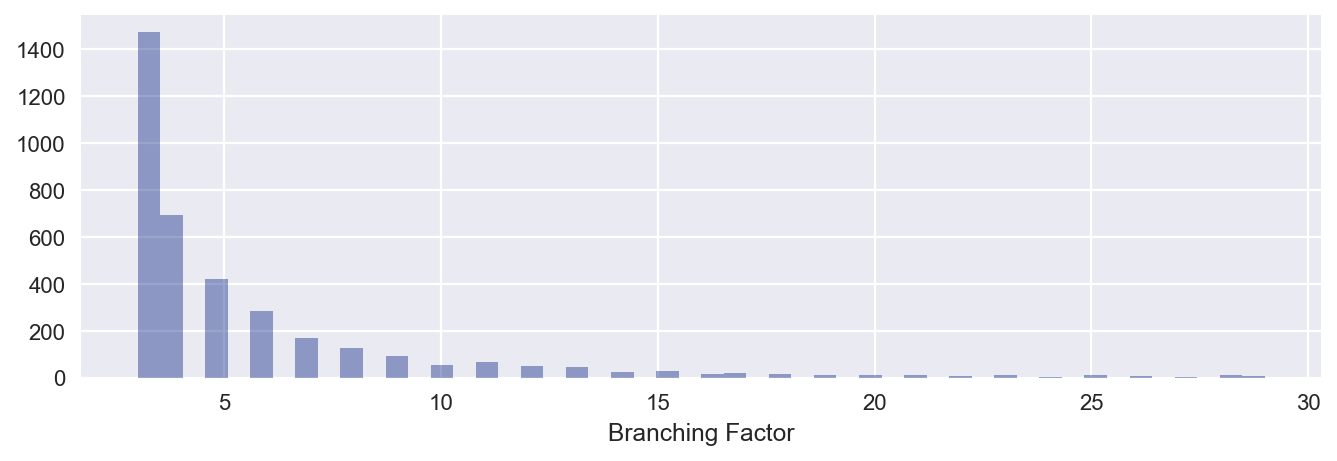

In [229]:
ax = sns.distplot([len(classes) for classes in map550.values() if len(classes) > 2 and len(classes) < 30],
             norm_hist=False, kde=False, axlabel="Branching Factor")
for label in ax.get_xticklabels():
    label.set_visible(True)

In [230]:
list(ax.get_xticklabels())

[Text(0,0,''),
 Text(5,0,'5'),
 Text(10,0,'10'),
 Text(15,0,'15'),
 Text(20,0,'20'),
 Text(25,0,'25'),
 Text(30,0,'30'),
 Text(0,0,'')]

# Find Similarities

In [682]:
count = 0
for t in train_550:
    if t[1][:-1] == [34, 282]:
        count += 1

In [121]:
title_labels = map_titles_to_labels(data550["title_to_id"], ml550["label_id"])

In [133]:
tokens_sets = {tuple(sorted(tokens)) for tokens in title_labels.values()}

In [130]:
equal = set()
for toks1 in tokens_sets[:-1]:
    for toks2 in tokens_sets[1:]:
        if toks1 == toks2:
            equal.add(tuple(toks1))

In [137]:
label_id = bidict(ml550["label_id"])

In [143]:
title_id = bidict(data550["title_to_id"])

In [144]:
label_copies = defaultdict(list)

for id_, labels in title_labels.items():
    label_copies[tuple(sorted(labels))].append(title_id.inv[id_])

In [146]:
[(k, v) for k, v in label_copies.items() if len(v) > 1]

[((5, 49), ['owner/operator', 'owner operator']),
 ((155, 248, 261), ['human resources manager', 'manager, human resources']),
 ((223, 260), ['programmer analyst', 'programmer/analyst']),
 ((29, 39, 41, 316),
  ['president & chief executive officer',
   'president and chief executive officer']),
 ((45, 59), ['director of sales', 'sales director']),
 ((15, 45), ['marketing director', 'director of marketing']),
 ((58, 104), ['server/bartender', 'bartender/server']),
 ((45, 235, 246),
  ['director of business development', 'director, business development'])]

In [295]:
mlpreds = (-sigmoid).argsort(axis=1)[:,:5]

In [321]:
title_id = bidict(data550["title_to_id"])

In [325]:
preds_550.bigram_pred = preds_550.bigram_pred.apply(lambda i: title_id.inv[i])
preds_550.PreLa_pred = preds_550.PreLa_pred.apply(lambda i: title_id.inv[i])
preds_550.multi_nb_pred = preds_550.multi_nb_pred.apply(lambda i: title_id.inv[i])
preds_550.fasttext_pred = preds_550.fasttext_pred.apply(lambda i: title_id.inv[i])

In [328]:
preds_550.target = preds_550.target.apply(lambda i: title_id.inv[i])

In [358]:
f1 = preds_550[preds_550.fasttext_correct_at == -1]
f2 = f1[f1.bigram_correct_at == -1]
f3 = f2[f2.multi_nb_correct_at == -1]
f4 = f3[f3.PreLa_correct_at == 0]

In [359]:
f4[["target", "bigram_pred", "PreLa_pred", "multi_nb_pred", "fasttext_pred"]]

,target,bigram_pred,PreLa_pred,multi_nb_pred,fasttext_pred
268,sandwich artist,cashier,sandwich artist,cashier,receptionist
12982,library assistant,administrative assistant,library assistant,administrative assistant,administrative assistant


In [331]:
in_ = data550["test_data"]

In [360]:
" => ".join([title_id.inv[i] for i in in_[268][1]])

'office clerk => sandwich artist => sandwich artist'

In [343]:
label_id = bidict(ml550["label_id"])

In [361]:
", ".join([label_id.inv[i] for i in mlpreds[268]])

'assistant, clerk, barista, production, sales'

# Length of Sequences

In [366]:
seqs_550 = [len(t[1]) for t in data550["train_data"] + data550["test_data"]]
seqs_7k = [len(t[1]) for t in data7k["train_data"] + data7k["test_data"]]

Text(0.5,1,'7k Titles Dataset')

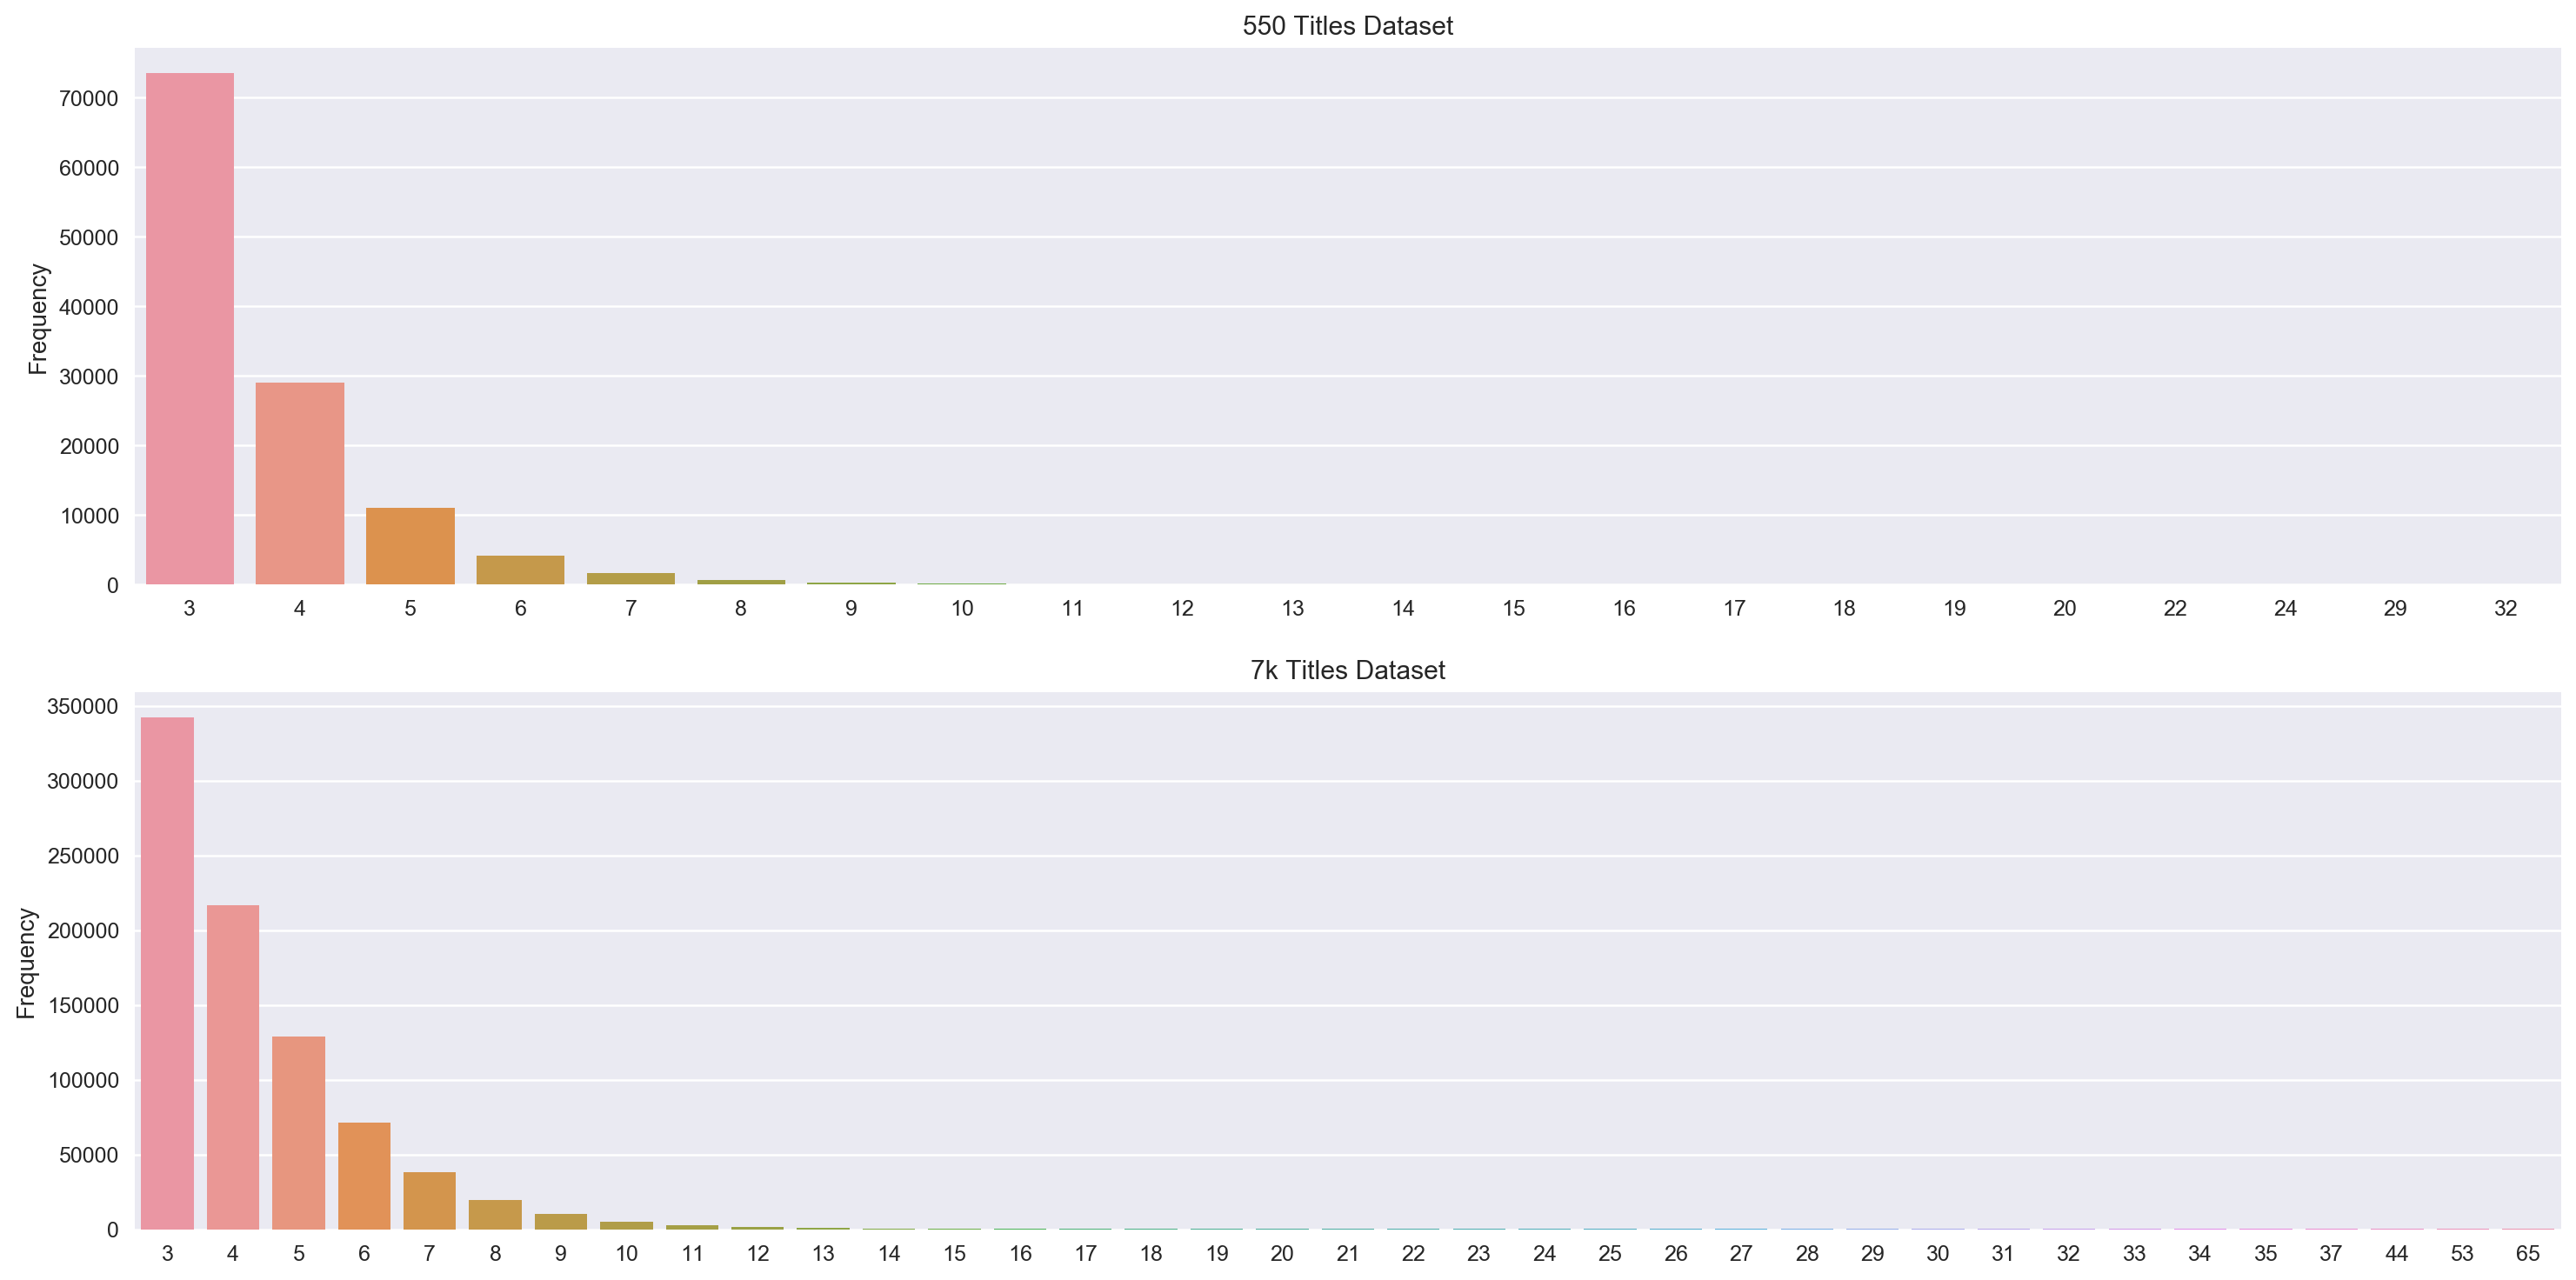

In [374]:
plt.rcParams['figure.dpi'] = 180
plt.rcParams['lines.linewidth'] = 0.8
fig, ax = plt.subplots(figsize=(20,10), ncols=1, nrows=2)
sns.countplot(seqs_550, ax=ax[0])
sns.countplot(seqs_7k, ax=ax[1])
ax[0].set_ylabel("Frequency")
ax[1].set_ylabel("Frequency")
ax[0].set_title('550 Titles Dataset')
ax[1].set_title('7k Titles Dataset')